### Helpers and packages

In [4]:

import spacy
import os 
import pandas
import requests
import bs4
import gensim
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import pearsonr

from openai import OpenAI
client = OpenAI(api_key= '') # insert your OpenAI API key here


nlp_es = spacy.load('es_core_news_sm')

def normalizeTokens_es(word_list, extra_stop=[], lemma = True):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp_es(word_list.lower(), disable=['parser', 'ner'])
    
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp_es.vocab[stopword]
            lexeme.is_stop = True

    if lemma:
        for w in doc:
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
                normalized.append(str(w.text.strip()))

    return normalized

def word_tokenize_es(word_list):
    tokenized = []
    doc = nlp_es(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def sent_tokenize_es(word_list, model=nlp_es):
    doc = model(word_list)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def senator_centroid(senator, model):
    senator = senator.lower().split(' ')
    return np.average([model.wv[x] for x in senator if x in vocab], axis=0)

def last_name_centroid(last_name, model):
    """
    Takes a list of strings and returns the centroid of the word vectors
    """
    last_name_vects = []
    for ln in last_name:
        if ln.lower() in model.wv.key_to_index:
            last_name_vects.append(senateW2V_CBOW.wv[ln.lower()])
    return np.average(last_name_vects, axis=0)

def cosine_similarity_adapter(x, y):
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0][0]

def clean_party_names(party):
    if 'Coalición Alianza Verde y Centro Esperanza' in party or 'ASI' in party:
        return 'Alianza Social Independiente'
    if party == 'Coalición Pacto Histórico - Polo Democrático':
        return 'Polo Democrático Alternativo'
    if 'MAIS' in party:
        return 'Movimiento Alternativo Indígena y Social'
    if 'Colombia Humana' in party:
        return 'Colombia Humana'
    if 'Unión Patriótica' in party:
        return 'Unión Patriótica'
    if 'Partido de la Unión por la Gente' in party:
        return 'Partido de la U'
    if 'Comunes' in party:
        return 'Comunes'
    if 'ADA' in party:
        return 'Alianza Democrática Amplia'
    if 'Democrático' in party:
        return 'Centro Democrático'
    return party

def assign_position(party):
    if party in government:
        return 'government'
    if party in independent:
        return 'independent'
    if party in opposition:
        return 'opposition'
    return 'other'

def gpt_embedding(string):
    """
    Gets the vector representation of a senator's name from GPT embeddings
    """
    response = client.embeddings.create(input = string,
                                        model="text-embedding-3-small")
    return response.data[0].embedding


## Preprocessing
### congress sessions corpus

In [10]:
# initialize corpus df

#get the text from the corpus
senateDict = {'name' : [], 'text' : []}
for file in os.listdir(r"C:\Users\asarr\Documents\Projects\word embeddings disgust in senate\Actas comisiones del senado 2023\clean documents"):
    if file.endswith(".txt"):
        senateDict['name'].append(file)
        with open(os.path.join(r"C:\Users\asarr\Documents\Projects\word embeddings disgust in senate\Actas comisiones del senado 2023\clean documents", file), 'r', encoding = 'utf8') as f:
            senateDict['text'].append(f.read())


senateDF = pandas.DataFrame(senateDict)
senateDF['tokenized_text'] = senateDF['text'].apply(lambda x: word_tokenize_es(x))
senateDF['normalized_tokens'] = senateDF['tokenized_text'].apply(lambda x: normalizeTokens_es(x, extra_stop=[]))
senateDF['tokenized_sents'] = senateDF['text'].apply(lambda x: [word_tokenize_es(s) for s in sent_tokenize_es(x)])
senateDF['normalized_sents'] = senateDF['tokenized_sents'].apply(lambda x: [normalizeTokens_es(s, lemma=False) for s in x])

### Congress members database

In [17]:
request = requests.get('https://www.senado.gov.co/index.php/el-senado/senadores?lastletter=Todos#modazdirectory')
soup = bs4.BeautifulSoup(request.text, 'html.parser')
senators = soup.find_all('div', class_= "modazdirectory__result modazdirectory__layout-misc_off")

senators_dict = {'senator':[], 'party':[]}
for senator in senators:
    senators_dict['senator'].append(senator.h3.text)
    senators_dict['party'].append(senator.find('p').text)

senatorsDF = pandas.DataFrame(senators_dict)

In [25]:
senatorsDF['last_names'] = senatorsDF['senator'].apply(lambda x: x.split(' ')[:2])

In [26]:
#clean the party columns
senatorsDF['party'] = senatorsDF['party'].apply(clean_party_names) 

In [27]:
#add position towards government
government = ['Polo Democrático Alternativo', 'Unión Patriótica', 'Colombia Humana', 
              'Movimiento Alternativo Indígena y Social', 'Comunes', 'Alianza Verde',
              'Pacto Histórico', 'Colombia Humana', 'Alianza Democrática Amplia']
independent = ['Partido Liberal', 'Autoridades Indigenas de Colombia - AICO',
               'Partido Conservador', 'Partido de la U', 'Sin Partido']
opposition = ['Centro Democrático', 'Partido Conservador', 'MIRA', 
              'Alianza Social Independiente', 'Colombia Justa Libres', 'Cambio Radical']

senatorsDF['position'] = senatorsDF['party'].apply(assign_position)

In [28]:
#add ethnic_identity to senatorsDF

ethnic_circunscriptions = ['Autoridades Indigenas de Colombia - AICO', 'Alianza Democrática Amplia']
cases = ['Pérez Pérez Catalina del Socorro','Quilcué Vivas Aída Marina', 
         'Riascos Riascos Paulino', 'Daza Cotes Imelda']
ethnic_identity = []
for senator in senatorsDF.iterrows():
    if senator[1]['party'] in ethnic_circunscriptions:
        ethnic_identity.append(1)
        continue
    elif senator[1]['senator'] in cases:
        ethnic_identity.append(1)
        continue
    else:
        ethnic_identity.append(0)

senatorsDF['ethnicity'] = ethnic_identity

In [29]:
#add gender to senatorsDF

genre_predict = ['mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'mujer',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'mujer',
 'hombre',
 'mujer',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre',
 'hombre']
sen_list = [senator for senator in senatorsDF['senator']]

genres_lst = [(sen_list[i], genre_predict[i], i) for i in range(len(sen_list))]
genres_lst_wrong = [4,9,14,16,17,27,38,39,44,45,59,62,66,67,69,82,85,87,92,100,104]

genre = []
for i in range(len(genres_lst)):
    if i in genres_lst_wrong:
        if genre_predict[i] == 'hombre':
            genre.append('female')
        else:
            genre.append('male')
    else:
        if genre_predict[i] == 'hombre':
            genre.append('male')
        else:
            genre.append('female')

senatorsDF['genre'] = genre
senatorsDF['gender'] = senatorsDF['genre'].apply(lambda x: 1 if x == 'male' else 0)
senatorsDF.drop(columns = ['genre'], inplace = True)



### SEL

In [31]:
#load SEL emotional dictionary

sel_path = r'C:\Users\asarr\Documents\MACSS\Winter 2024\Computational Content Analysis\colombian-congress-nlp\Spanish emotional lexicon\SEL.txt'
sel = pandas.read_csv(sel_path, sep="\t", names=["word", "probability", "category"], encoding = 'ISO-8859-1')
sel = sel.drop(0)

sel['probability'] = sel['probability'].astype(float)


In [32]:
#iterate over rows and add words to the dictionary according to their category
positives_lst = {}
for index, row in sel.iterrows():
    if row['category'] not in positives_lst:
        positives_lst[row['category']] = []
    positives_lst[row['category']].append(row['word'])

### Word2Vec embeddings

In [33]:
#create word2vec model
senateW2V_CBOW = gensim.models.word2vec.Word2Vec(senateDF['normalized_sents'].sum(), sg=0, window=6)
senateW2V_SG = gensim.models.word2vec.Word2Vec(senateDF['normalized_sents'].sum(), sg=1, window=6)
vocab = list(senateW2V_CBOW.wv.key_to_index.keys())

In [34]:
#remove words in positives_lst that are not in the vocabulary
positives_lst_vocab = {'Alegría': [], 'Enojo': [], 'Repulsión': [], 'Sorpresa': [], 'Tristeza': [], 'Miedo': []}

#create positives
for emotion in positives_lst.keys():
    for word in positives_lst[emotion]:
        if word in vocab:
            positives_lst_vocab[emotion].append(word)

In [35]:
#expanding the emotional vocabulary
add_disgust_words = '''repulsivo
nauseoso
repelente
despreciable
despectivo
vilipendiar
abyecto
lúgubre
macabro
morbidez
siniestro
ominoso
depravado
deshonroso
escarnio
vilipendiado
execración
aborrecible
desdén
menosprecio
reprobable
repugnante
nauseabundo
detestación
repulsión
oprobio
ignominia
infamia
inmundicia
suciedad
escoria
podredumbre
deterioro
descomposición
fetidez
maloliente
alevosía
antihigiénico
insalubre
pestilencia
sarna
escabiosis
piojos
verminoso
larvas
parásitos
contagioso
epidémico
pandémico
virulento
bacteria
viral
contagio
infeccioso
tóxico
venenoso
nocivo
perjudicial
dañino
maligno
cancerígeno
carcinógeno
mutágeno
tétano
rabioso
septicemia
gangrena
necrosis
ulceroso
llaga
pústula
absceso
forúnculo
carbunco
escrófula
lepra
sífilis
gonorrea
herpes
VIH
SIDA
hepatitis
cirrosis
tuberculosis
meningitis
poliomielitis
dengue
zika
chikungunya
malaria
fiebre
ébola
sarcoma
melanoma
linfoma
leucemia
carcinomatosis
metástasis
quimioterapia
radioterapia
inmuno-supresión
autoinmune
alérgeno
histamina
anafilaxia
anafiláctico
urticaria
eczema
psoriasis
dermatitis
acné
rosácea
impétigo
celulitis
caspa
seborrea
calvicie
alopecia
hirsutismo
onicomicosis
verruga
papiloma
condiloma
quiste
lipoma
fibroma
adenoma
carcinoma
sarcoma
melanoma
necrópolis
sepulcro
tumba
cripta
mausoleo
catacumba
osario
fosa
cadáver
despojo
restos
esqueleto
calavera
huesos
caries
gingivitis
periodontitis
halitosis
sialorrea
dispepsia
úlcera
gastritis
colitis
hemorroides
anal
prolaps
incontinencia
diarrea
estreñimiento
flatulencia
eructo
regurgitación
vómito
ictericia
ascitis
edema
linfedema
hidropesía
anasarca
cianosis
hipoxia
asfixia
estrangulación
ahogamiento
intoxicación
envenenamiento
sobredosis
adicción
dependencia
abstinencia
psicosis
esquizofrenia
paranoia
neurosis
psicopatía
sadismo
masoquismo
necrofilia
pedofilia
incesto
violación
abuso
maltrato
tortura
genocidio
holocausto
apartheid'''
add_disgust_words = add_disgust_words.split('\n')
for word in add_disgust_words:
    if word in vocab:
        positives_lst_vocab['Repulsión'].append(word)

In [36]:
disgust_lst = positives_lst_vocab['Repulsión']

In [37]:
#calculate centroid for each emotion
centroids = {'Alegría': [], 'Enojo': [], 'Repulsión': [], 'Sorpresa': [], 'Tristeza': [], 'Miedo': []}

for emotion in centroids.keys():
    centroids[emotion] = np.average([senateW2V_CBOW.wv[x] for x in positives_lst_vocab[emotion]], axis=0)

centroids['General'] = np.average([senateW2V_CBOW.wv[x] for x in vocab], axis=0)

In [38]:
senatorsDF['centroid'] = senatorsDF['senator'].apply(lambda x: senator_centroid(x, senateW2V_CBOW))
senatorsDF['last_names_centroid'] = senatorsDF['last_names'].apply(lambda x: last_name_centroid(x, senateW2V_CBOW))

c:\Users\asarr\anaconda3\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


### GPT embeddigns

In [42]:
senatorsDF['gpt_vectors'] = senatorsDF['senator'].apply(gpt_embedding)

In [44]:
#calculate the disgust centroid
disgust_gpt_vectors = [gpt_embedding(word) for word in disgust_lst]
disgust_centroid = np.average(disgust_gpt_vectors, axis=0)

In [45]:
#add to the dataframe
senatorsDF['gpt_vectors'] = senatorsDF['gpt_vectors'].apply(lambda x: np.asarray(x))

### Cosine similarities

In [55]:
#calculate cosine similarity between each senator and each emotion
senatorsDF['disgust_cs'] = senatorsDF['centroid'].apply(lambda x: cosine_similarity_adapter(x, centroids['Repulsión']))

In [48]:
senatorsDF['disgust_gpt_cs'] = senatorsDF['gpt_vectors'].apply(lambda x: cosine_similarity_adapter(x, disgust_centroid))

In [49]:
senatorsDF['disgust_cs_diff'] = senatorsDF['disgust_cs'] - senatorsDF['disgust_gpt_cs']

## Visualizations

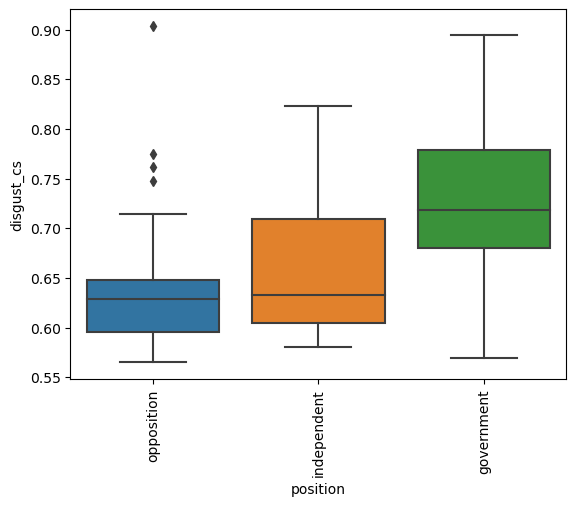

In [52]:
#boxlplot of disgust_cs by position

sns.boxplot(x='position', y='disgust_cs', data=senatorsDF)
plt.xticks(rotation=90)
plt.show()

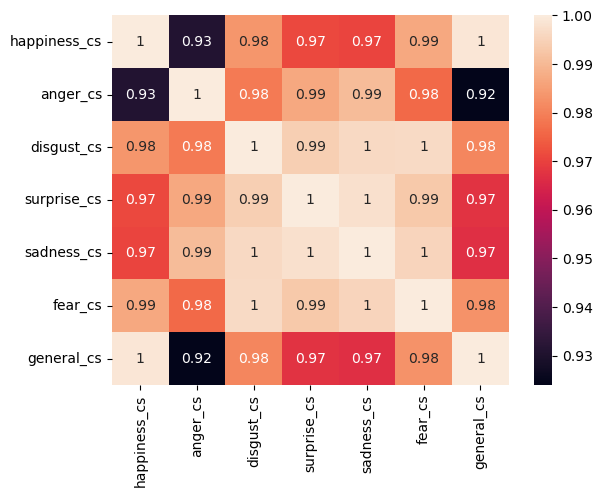

In [41]:
#graph correlation between all emotions
correlation = senatorsDF[['happiness_cs', 'anger_cs', 'disgust_cs', 'surprise_cs', 'sadness_cs', 'fear_cs', 'general_cs']].corr()
sns.heatmap(correlation, annot=True)
plt.show()

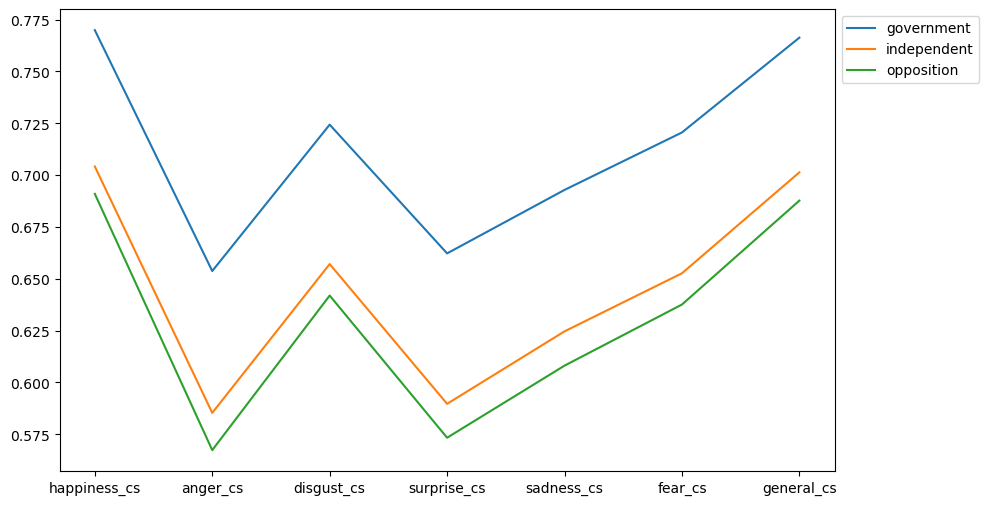

In [56]:
#make a line plot of the average disgust_cs by party, move legend to the bottom
emotion_cols = ['happiness_cs', 'anger_cs', 'disgust_cs', 'surprise_cs', 'sadness_cs', 'fear_cs', 'general_cs']
avg_emotions = senatorsDF.groupby('position')[emotion_cols].mean().T
plt.figure(figsize=(10, 6))
for party in avg_emotions.columns:
    plt.plot(avg_emotions.index, avg_emotions[party], label=party)

plt.legend(loc='best', bbox_to_anchor=(1,1))

<Axes: xlabel='position', ylabel='disgust_cs'>

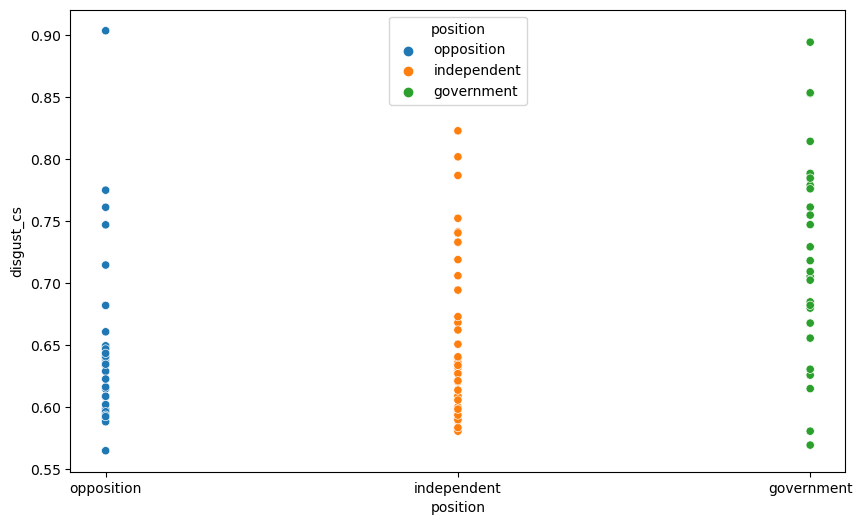

In [57]:
#do a scatterplot of disgust for every senator
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='position', y='disgust_cs', data=senatorsDF, hue='position')

### tsne graph

In [58]:
import random
random.seed(0)
senators_to_use_gov = senatorsDF.query('position == "government"')
# senators_to_use_gov = random.sample(senators_to_use_gov['senator'].to_list(), len(senators_to_use_gov) // 2)
senators_to_use_gov = senators_to_use_gov['senator'].to_list()


senators_to_use_opp = senatorsDF.query('position == "opposition"')
# senators_to_use_opp = random.sample(senators_to_use_opp['senator'].to_list(), len(senators_to_use_opp) // 2)
senators_to_use_opp = senators_to_use_opp['senator'].to_list()

senators_to_use_ind = senatorsDF.query('position == "independent"')
# senators_to_use_ind = random.sample(senators_to_use_ind['senator'].to_list(), len(senators_to_use_ind) // 2)
senators_to_use_ind = senators_to_use_ind['senator'].to_list()

senators_to_use = senators_to_use_gov + senators_to_use_opp + senators_to_use_ind

In [59]:
disgust_vectors_w2v = {word:senateW2V_CBOW.wv[word] for word in disgust_lst}
senator_vectors_w2v = {senator:senator_centroid(senator, senateW2V_CBOW) for senator in senatorsDF['senator'] if senator in senators_to_use}

senator_vectors_gpt = {}
for row in senatorsDF.iterrows():
    if row[1]['senator'] in senators_to_use:
        senator_vectors_gpt[row[1]['senator']] = row[1]['gpt_vectors']
disgust_vectors_gpt_dict = {}
for i in range(len(disgust_lst)):
    disgust_vectors_gpt_dict[disgust_lst[i]] = disgust_gpt_vectors[i]

In [60]:
#join the two dictionaries
senator_vectors_w2v.update(disgust_vectors_w2v)
senator_vectors_gpt.update(disgust_vectors_gpt_dict)

In [61]:
disgust_matrix_w2v = np.array(list(disgust_vectors_w2v.values()))
graph_matrix_w2v = np.array(list(senator_vectors_w2v.values()))

In [62]:
disgust_matrix_gpt = np.array(list(disgust_vectors_gpt_dict.values()))
graph_matrix_gpt = np.array(list(senator_vectors_gpt.values()))

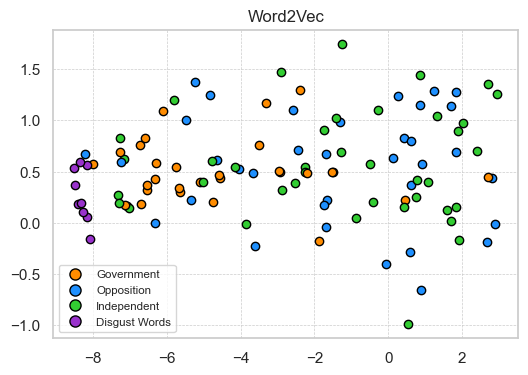

In [81]:
#t-SNE
# tsne_model = TSNE(n_components=2, random_state=0, perplexity=45)
# tsne_w2v = tsne_model.fit_transform(graph_matrix_w2v)

# Plotting
plt.figure(figsize=(6, 4))
for word, coord in zip(senator_vectors_w2v.keys(), tsne_w2v):
    if word in senators_to_use_gov:
        plt.scatter(coord[0], coord[1], color='#FF8C00', edgecolors='black')
    elif word in senators_to_use_opp:
        plt.scatter(coord[0], coord[1], color='#1E90FF', edgecolors='black')
    elif word in senators_to_use_ind:
        plt.scatter(coord[0], coord[1], color='#32CD32', edgecolors='black')
    else:
        plt.scatter(coord[0], coord[1], color='#9932CC', edgecolors='black')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF8C00', markersize=10, label='Government', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1E90FF', markersize=10, label='Opposition', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#32CD32', markersize=10, label='Independent', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#9932CC', markersize=10, label='Disgust Words', markeredgecolor='black')
]
plt.legend(handles=legend_handles, loc='best', fontsize='x-small', markerscale=0.8)
plt.title('Word2Vec')
plt.show()

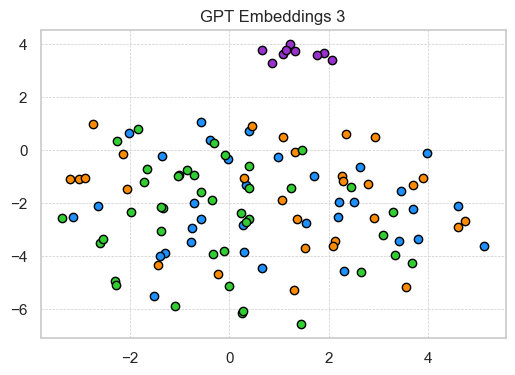

In [83]:
#t-SNE
tsne_model = TSNE(n_components=2, random_state=0, perplexity=45)
tsne_w2v = tsne_model.fit_transform(graph_matrix_gpt)

# Plotting
plt.figure(figsize=(6, 4))
for word, coord in zip(senator_vectors_gpt.keys(), tsne_w2v):
    if word in senators_to_use_gov:
        plt.scatter(coord[0], coord[1], color='#FF8C00', edgecolors='black')
    elif word in senators_to_use_opp:
        plt.scatter(coord[0], coord[1], color='#1E90FF', edgecolors='black')
    elif word in senators_to_use_ind:
        plt.scatter(coord[0], coord[1], color='#32CD32', edgecolors='black')
    else:
        plt.scatter(coord[0], coord[1], color='#9932CC', edgecolors='black')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF8C00', markersize=10, label='Government', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1E90FF', markersize=10, label='Opposition', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#32CD32', markersize=10, label='Independent', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#9932CC', markersize=10, label='Disgust Words', markeredgecolor='black')
]
plt.title('GPT Embeddings 3')
plt.show()

### boxplots

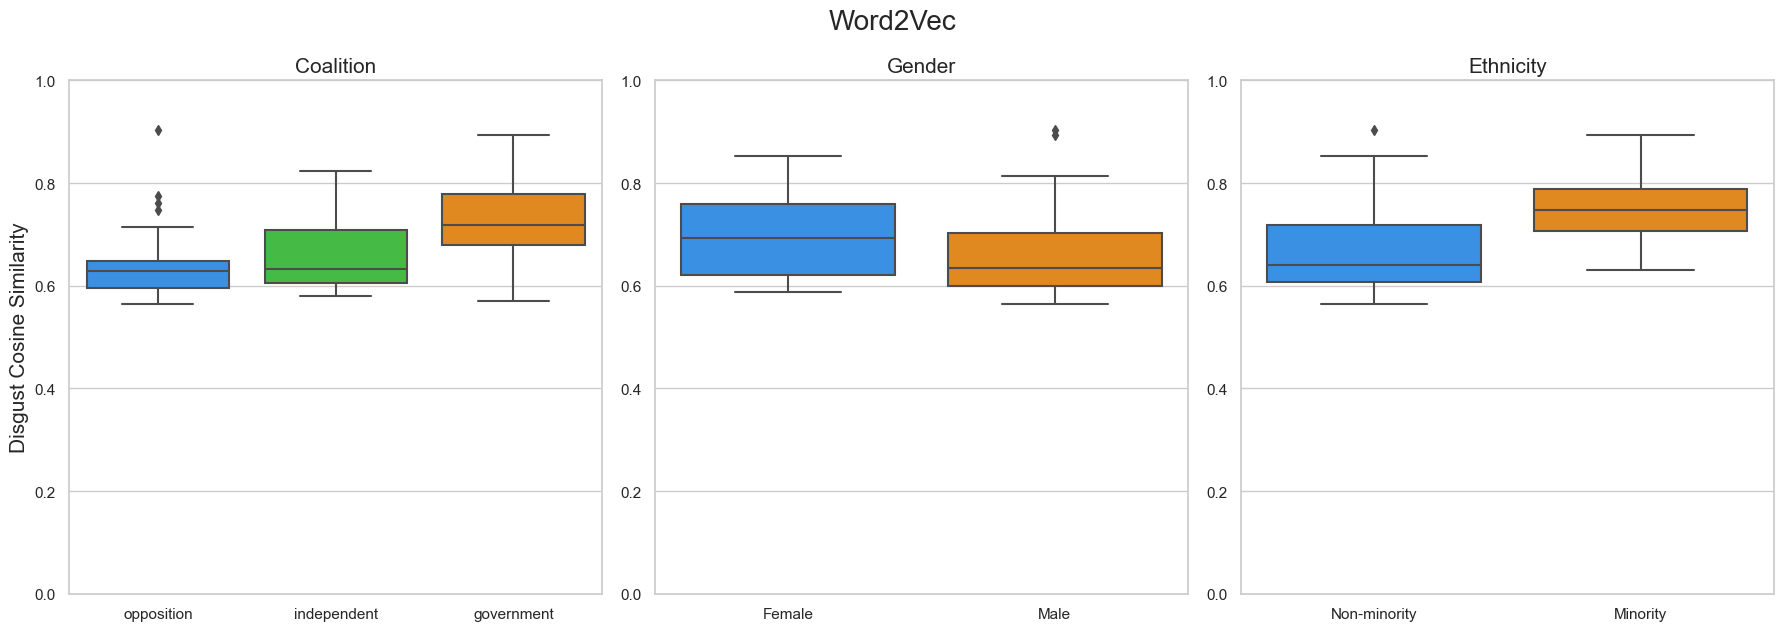

In [64]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

senatorsDF['gender_label'] = senatorsDF['gender'].map({1: 'Male', 0: 'Female'})
senatorsDF['ethnicity_label'] = senatorsDF['ethnicity'].map({0: 'Non-minority', 1: 'Minority'})

# Create box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Position vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[0], data=senatorsDF, x='position', y='disgust_cs', palette={"government": "#FF8C00", "opposition": "#1E90FF", "independent": "#32CD32"})
axes[0].set_title('Coalition', fontsize=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Disgust Cosine Similarity', fontsize=15)
axes[0].set_ylim(0, 1)

# Gender vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[1], data=senatorsDF, x='gender_label', y='disgust_cs', palette={'Male': "#FF8C00", 'Female': "#1E90FF"})
axes[1].set_title('Gender', fontsize=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)

# Ethnicity vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[2], data=senatorsDF, x='ethnicity_label', y='disgust_cs', palette={'Non-minority': "#1E90FF", 'Minority': "#FF8C00"}, )
axes[2].set_title('Ethnicity', fontsize=15)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 1)

# Adjust layout
plt.tight_layout()

# Show plot
fig.suptitle('Word2Vec', fontsize=20, y=1.05)
plt.show()


[<Axes: > <Axes: > <Axes: >]


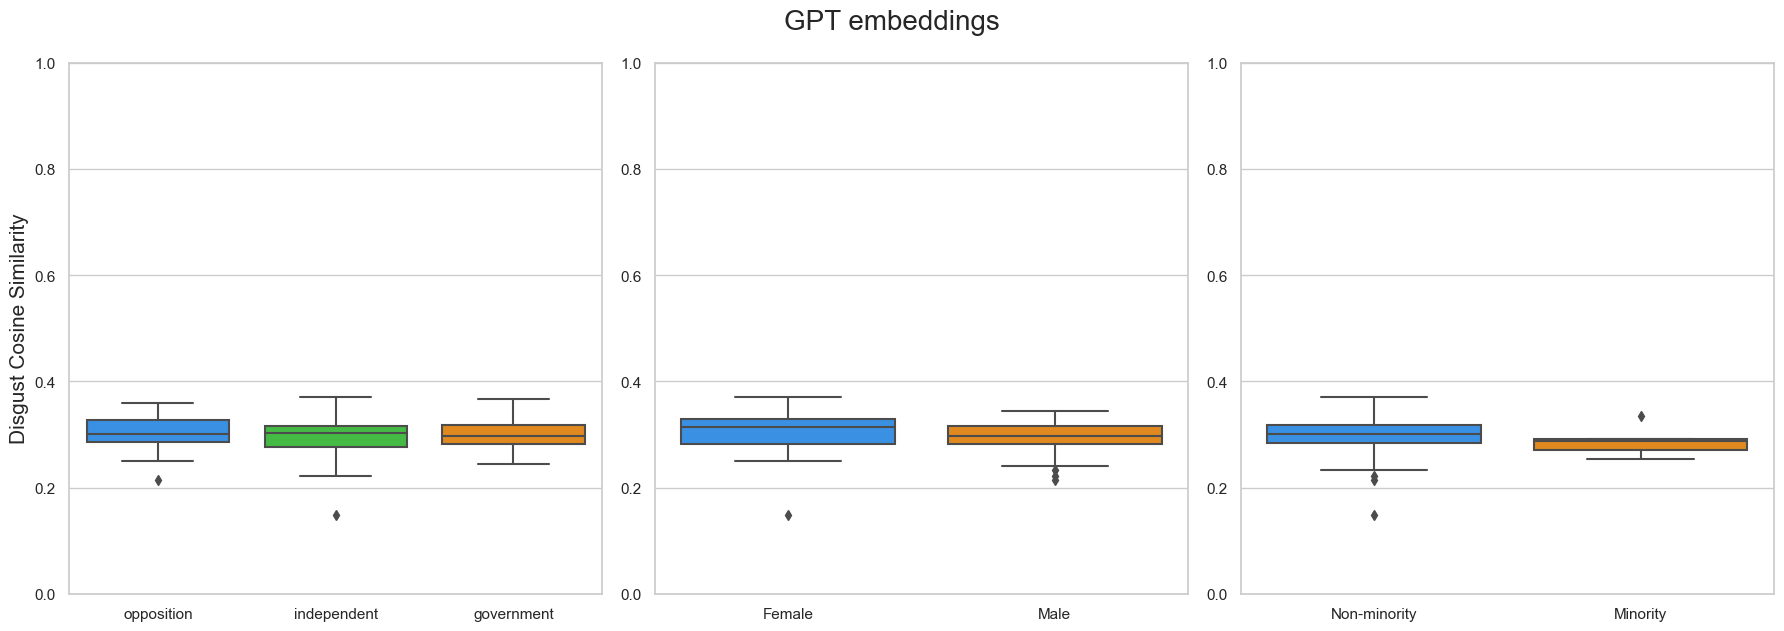

In [65]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create box plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
print(axes)

# Position vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[0], data=senatorsDF, x='position', y='disgust_gpt_cs', palette={"government": "#FF8C00", "opposition": "#1E90FF", "independent": "#32CD32"})
axes[0].set_xlabel('')
axes[0].set_ylabel('Disgust Cosine Similarity', fontsize=15)
axes[0].set_ylim(0, 1)
axes[0].set_ylim(0, 1)

# Gender vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[1], data=senatorsDF, x='gender_label', y='disgust_gpt_cs', palette={'Male': "#FF8C00", 'Female': "#1E90FF"})
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)

# Ethnicity vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[2], data=senatorsDF, x='ethnicity_label', y='disgust_gpt_cs', palette={'Non-minority': "#1E90FF", 'Minority': "#FF8C00"}, )
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 1)

# Adjust layout
plt.tight_layout()

# Show plot
fig.suptitle('GPT embeddings', fontsize=20, y=1.05)

plt.show()

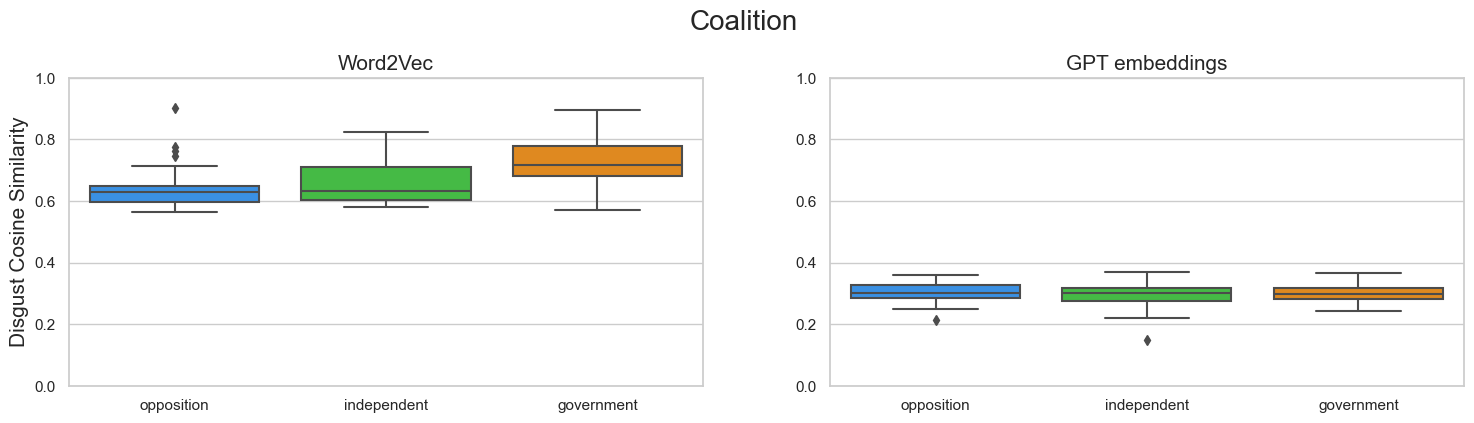

In [66]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

senatorsDF['gender_label'] = senatorsDF['gender'].map({1: 'Male', 0: 'Female'})
senatorsDF['ethnicity_label'] = senatorsDF['ethnicity'].map({0: 'Non-minority', 1: 'Minority'})

# Create box plots
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Position vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[0], data=senatorsDF, x='position', y='disgust_cs', palette={"government": "#FF8C00", "opposition": "#1E90FF", "independent": "#32CD32"})
axes[0].set_title('Word2Vec', fontsize=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Disgust Cosine Similarity', fontsize=15)
axes[0].set_ylim(0, 1)

sns.boxplot(ax=axes[1], data=senatorsDF, x='position', y='disgust_gpt_cs', palette={"government": "#FF8C00", "opposition": "#1E90FF", "independent": "#32CD32"})
axes[1].set_title('GPT embeddings', fontsize=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)
axes[1].set_ylim(0, 1)


fig.suptitle('Coalition', fontsize=20, y=1.05)
plt.show()


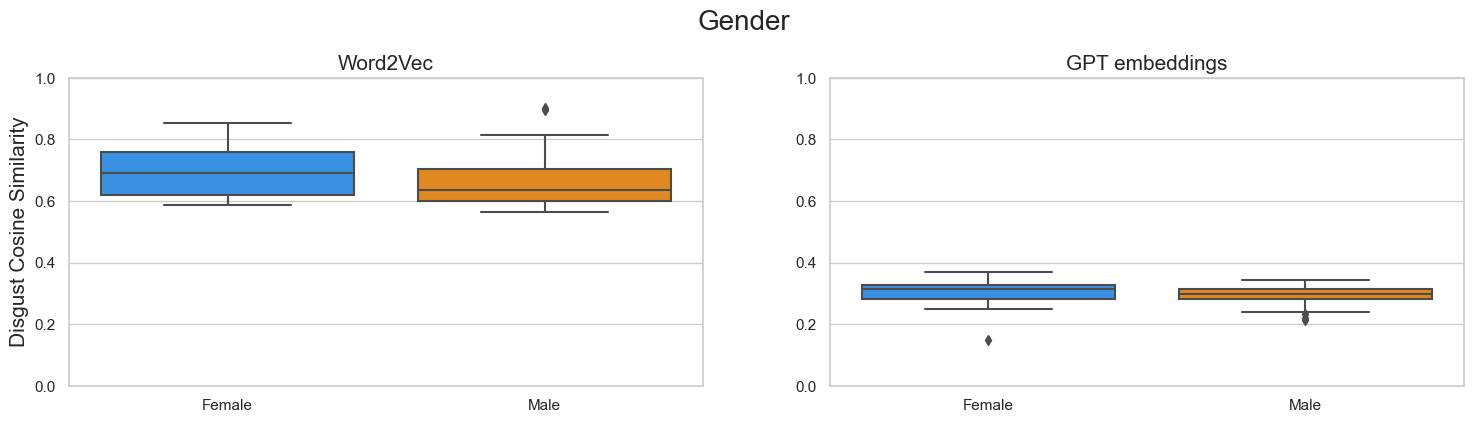

In [67]:
sns.set_theme(style="whitegrid")

senatorsDF['gender_label'] = senatorsDF['gender'].map({1: 'Male', 0: 'Female'})
senatorsDF['ethnicity_label'] = senatorsDF['ethnicity'].map({0: 'Non-minority', 1: 'Minority'})

fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Position vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[0], data=senatorsDF, x='gender_label', y='disgust_cs', palette={'Male': "#FF8C00", 'Female': "#1E90FF"})
axes[0].set_title('Word2Vec', fontsize=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Disgust Cosine Similarity', fontsize=15)
axes[0].set_ylim(0, 1)

sns.boxplot(ax=axes[1], data=senatorsDF, x='gender_label', y='disgust_gpt_cs', palette={'Male': "#FF8C00", 'Female': "#1E90FF"})
axes[1].set_title('GPT embeddings', fontsize=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)


fig.suptitle('Gender', fontsize=20, y=1.05)
plt.show()


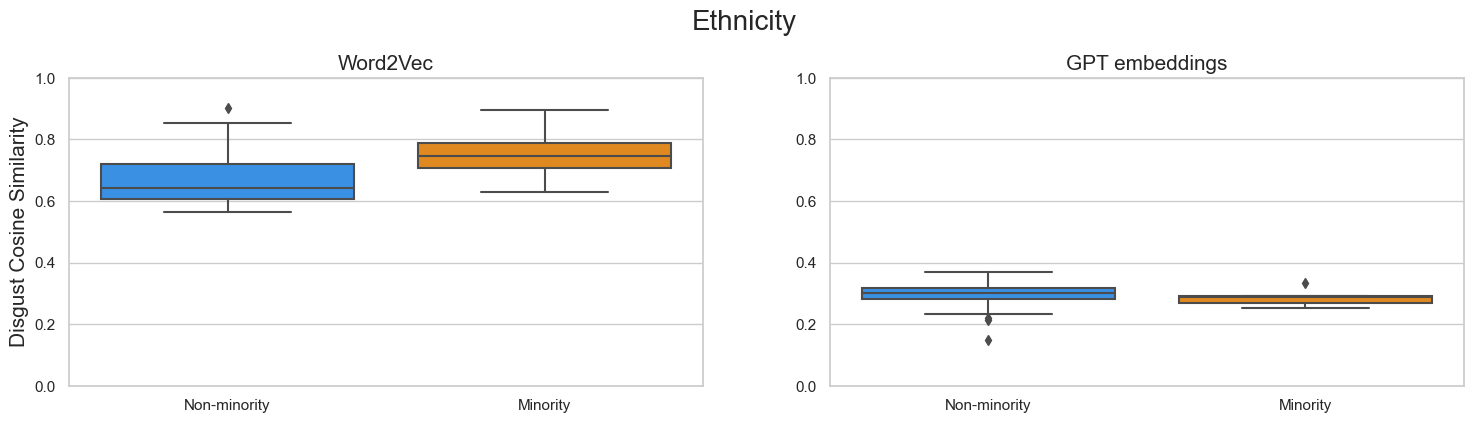

In [68]:
sns.set_theme(style="whitegrid")

senatorsDF['ethnicity_label'] = senatorsDF['ethnicity'].map({0: 'Non-minority', 1: 'Minority'})

fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# ethnicit vs. Disgust Cosine Similarity
sns.boxplot(ax=axes[0], data=senatorsDF, x='ethnicity_label', y='disgust_cs', palette={'Non-minority': "#1E90FF", 'Minority': "#FF8C00"})
axes[0].set_title('Word2Vec', fontsize=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('Disgust Cosine Similarity', fontsize=15)
axes[0].set_ylim(0, 1)

sns.boxplot(ax=axes[1], data=senatorsDF, x='ethnicity_label', y='disgust_gpt_cs', palette={'Non-minority': "#1E90FF", 'Minority': "#FF8C00"})
axes[1].set_title('GPT embeddings', fontsize=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 1)

fig.suptitle('Ethnicity', fontsize=20, y=1.05)
plt.show()

In [84]:
#correlation between disgust_cs and disgust_gpt_cs
senatorsDF[['disgust_cs', 'disgust_gpt_cs']].corr()

#pearson correlation coefficient
pearsonr(senatorsDF['disgust_cs'], senatorsDF['disgust_gpt_cs'])

PearsonRResult(statistic=-0.08731621157831784, pvalue=0.37811387978715827)

In [70]:
# Means and standard deviations of disgust_cs grouped by position
means_position = senatorsDF.groupby('position')['disgust_cs'].mean()
stds_position = senatorsDF.groupby('position')['disgust_cs'].std()

# Means and standard deviations of disgust_cs grouped by gender
means_gender = senatorsDF.groupby('gender')['disgust_cs'].mean()
stds_gender = senatorsDF.groupby('gender')['disgust_cs'].std()

# Means and standard deviations of disgust_cs grouped by ethnicity
means_ethnicity = senatorsDF.groupby('ethnicity')['disgust_cs'].mean()
stds_ethnicity = senatorsDF.groupby('ethnicity')['disgust_cs'].std()

# Means and standard deviations of disgust_gpt_cs grouped by position
means_position_gpt = senatorsDF.groupby('position')['disgust_gpt_cs'].mean()
stds_position_gpt = senatorsDF.groupby('position')['disgust_gpt_cs'].std()

# Means and standard deviations of disgust_gpt_cs grouped by gender
means_gender_gpt = senatorsDF.groupby('gender')['disgust_gpt_cs'].mean()
stds_gender_gpt = senatorsDF.groupby('gender')['disgust_gpt_cs'].std()

# Means and standard deviations of disgust_gpt_cs grouped by ethnicity
means_ethnicity_gpt = senatorsDF.groupby('ethnicity')['disgust_gpt_cs'].mean()
stds_ethnicity_gpt = senatorsDF.groupby('ethnicity')['disgust_gpt_cs'].std()


In [71]:
senatorsDF['disgust_cs_diff'] = senatorsDF['disgust_cs'] - senatorsDF['disgust_gpt_cs']
senatorsDF['disgust_cs_diff'].describe()

count    104.000000
mean       0.372874
std        0.087988
min        0.230963
25%        0.310995
50%        0.347351
75%        0.431972
max        0.624415
Name: disgust_cs_diff, dtype: float64

In [73]:
senatorsDF['disgust_cs'].describe()

count    104.000000
mean       0.670743
std        0.078409
min        0.565109
25%        0.608834
50%        0.642278
75%        0.730252
max        0.903404
Name: disgust_cs, dtype: float64

In [74]:
senatorsDF['disgust_gpt_cs'].describe()

count    104.000000
mean       0.297869
std        0.033661
min        0.148381
25%        0.282514
50%        0.300359
75%        0.317748
max        0.370044
Name: disgust_gpt_cs, dtype: float64

<Axes: >

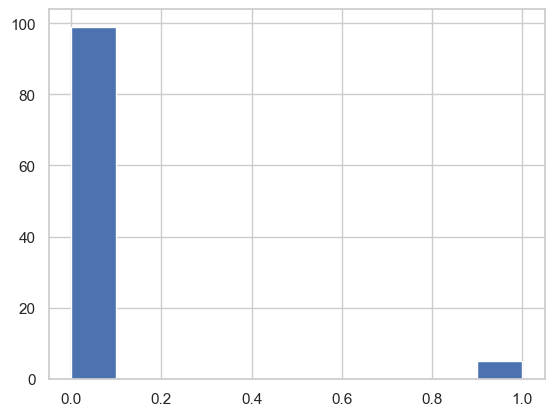

In [89]:
senatorsDF['ethnicity'].hist()

In [76]:
#t test between disgust_cs and disgust_gpt_cs
from scipy.stats import ttest_ind
ttest_ind(senatorsDF['disgust_cs'], senatorsDF['disgust_gpt_cs'])

TtestResult(statistic=44.56384363694767, pvalue=9.744156951735375e-108, df=206.0)